In [22]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import h5py
import os

%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import sys
sys.path.append('/reg/neh/home/qiaoshen/GitHub/loki/src/utils/')
from postproc_helper import *
sys.path.append('/reg/neh/home/qiaoshen/GitHub/loki/src/RingData/')
from DiffCorr import DiffCorr
import stable

from scipy.interpolate import interp1d
from scipy.signal import find_peaks_cwt

from scipy.optimize import curve_fit

import matplotlib as mpl
mpl.rcParams['font.serif'] = "Bitstream Vera Serif"
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['font.size'] = 18

from matplotlib.gridspec import GridSpec

In [2]:
def normalize_shot(ss, this_mask):
    if ss.dtype != 'float64':
        # shots need to be float64 or more. 
        # float32 resulted in quite a bit of numerical error 
        ss = ss.astype(np.float64)
    
    ss *=this_mask
    mean_ss = ss.sum(-1)/this_mask.sum(-1) 
    ss = ss-mean_ss[:,None]
    return np.nan_to_num(ss*this_mask)

def make_elbow_plot( data, max_nclust=12, skip = 1):
    """data is Nexample x Nfeatures """
    elbow_plot = []

    for i in xrange( 1, max_nclust+1, skip):
        print("TRygin kmeans with %d clusters (up to %d)"%(i, max_nclust))
        kmeans = KMeans( n_clusters=i)
        kmeans.fit( data)
        elbow_plot.append( kmeans.score(data))
#     plt.xlabel('# of clusters')
#     plt.ylabel('how good is the clustering')
#     plt.plot( np.arange( 1, max_nclust+1), elbow_plot, '.')

#     plt.show()
    return np.arange( 1, max_nclust+1, skip), elbow_plot

def normalize(d):
    x=d.copy()
    x-=x.min()
    return x/(x.max()-x.min())

def normalize_set(GDPdiff):
    norm_GDP_diff = np.zeros_like(GDPdiff)
    for iq in range(GDPdiff.shape[0]):
        norm_GDP_diff[iq] = normalize(GDPdiff[iq])
    return norm_GDP_diff

In [3]:
qvalue = np.load('/reg/neh/home/qiaoshen/dissertation_notebooks/qvalues.npy')
exp_cpsi = np.load('/reg/neh/home/qiaoshen/dissertation_notebooks/exp_cpsi.npy')

In [4]:
run_num=31
PT_dir = '/reg/d/psdm/cxi/cxilp6715/scratch/combined_tables/finer_q/'
f_PI=h5py.File(os.path.join(PT_dir,'run%d.tbl'%run_num),'r')
print f_PI.keys()
mask = f_PI['polar_mask_binned'].value
mask = (mask==mask.max())
shots = f_PI['polar_imgs'].value[:10000]

norm_shots = np.zeros_like(shots, dtype=np.float64)
for idx,ss in enumerate(shots):
    if np.nan_to_num(ss).sum<=0:
        continue
    norm_shots[idx]=normalize_shot(ss,mask)
shots_to_use=norm_shots.copy()
# norm_shots=norm_shots/norm_shots.mean(-1)[:,:,None]
# 
phi_offset=30
num_phi=norm_shots.shape[-1]
qs = np.linspace(0,1,shots.shape[1])
dc=DiffCorr(mask[None,:,:],qs,0,pre_dif=True)
mask_corr=dc.autocorr()

dc = DiffCorr(norm_shots-norm_shots.mean(0)[None,:,:],
  qs,0,pre_dif=True)
corr = dc.autocorr()

corr/=mask_corr
corr=corr[:,:,phi_offset:num_phi/2-phi_offset]

diff_shots = norm_shots[::2]-norm_shots[1::2]

[u'ebeam', u'event_time', u'evr', u'fiducials', u'gas_detector', u'phase_cav', u'polar_imgs', u'polar_mask', u'polar_mask_binned', u'polar_params', u'radial_profs']


0.108068640058


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

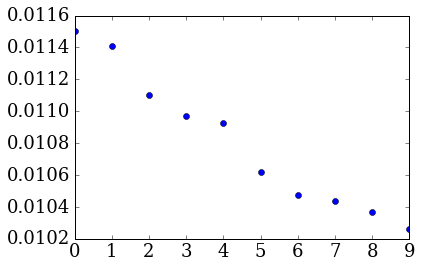

In [28]:
qidx=19
pca=PCA(n_components=10)

new_corr=pca.fit_transform(corr[:,qidx,:])
print pca.explained_variance_ratio_.sum()
plt.plot( pca.explained_variance_ratio_,'o')
kmeans=KMeans(n_clusters=15)
kmeans.fit(new_corr)

TRygin kmeans with 1 clusters (up to 40)
TRygin kmeans with 3 clusters (up to 40)
TRygin kmeans with 5 clusters (up to 40)
TRygin kmeans with 7 clusters (up to 40)
TRygin kmeans with 9 clusters (up to 40)
TRygin kmeans with 11 clusters (up to 40)
TRygin kmeans with 13 clusters (up to 40)
TRygin kmeans with 15 clusters (up to 40)
TRygin kmeans with 17 clusters (up to 40)
TRygin kmeans with 19 clusters (up to 40)
TRygin kmeans with 21 clusters (up to 40)
TRygin kmeans with 23 clusters (up to 40)
TRygin kmeans with 25 clusters (up to 40)
TRygin kmeans with 27 clusters (up to 40)
TRygin kmeans with 29 clusters (up to 40)
TRygin kmeans with 31 clusters (up to 40)
TRygin kmeans with 33 clusters (up to 40)
TRygin kmeans with 35 clusters (up to 40)
TRygin kmeans with 37 clusters (up to 40)
TRygin kmeans with 39 clusters (up to 40)


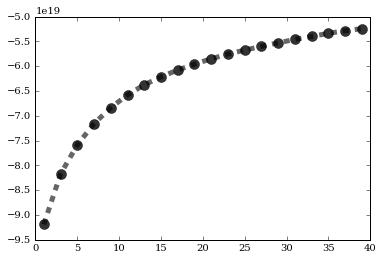

In [6]:
n_cluster, elbow=make_elbow_plot(new_corr, max_nclust=40, skip = 2)
plt.plot(n_cluster, elbow,'k.', markersize = 20, alpha = 0.8)
plt.plot(n_cluster, elbow,'k--',linewidth = 5, alpha = 0.6)

In [7]:
qs = np.linspace(0.2,0.88,35)

all_ac=[]
num_shots=[]
ave_cluster_shots=[]
ave_cluster_corr = []
ave_cluster_single_corr=[]
for ll in np.unique(kmeans.labels_):

    ss=shots_to_use[kmeans.labels_==ll]
    if ss.shape[0]<2:
        continue
    if ss.shape[0]%2>0:
        ss = ss[:-1]
    this_mask=mask.copy()
    
    dc=DiffCorr(this_mask[None,:,:],qs,0,pre_dif=True)
    mask_ac=dc.autocorr()
    
    ss_diff = ss[::2]-ss[1::2]
    dc=DiffCorr(ss_diff,qs,0,pre_dif=True)
    ac=dc.autocorr()/mask_ac
    
    all_ac.append(ac)
    num_shots.append(ac.shape[0])
    
    ave_cluster_shots.append(ss_diff.mean(0))
    ave_cluster_corr.append(ac.mean(0))
    
    ave_cluster_single_corr.append( corr[kmeans.labels_==ll].mean(0) )
    
combined_ac=np.concatenate(all_ac)
total_num_shots=np.sum(num_shots)

dc=DiffCorr(diff_shots,qs,0,pre_dif=False)
no_cluster_ac=dc.autocorr()/mask_ac

num_shots= np.array(num_shots)

In [8]:
norm_combined_ac = normalize_set(combined_ac[:,qidx,phi_offset:num_phi/2-phi_offset])
norm_no_clus_ac = normalize_set(no_cluster_ac[:,qidx,phi_offset:num_phi/2-phi_offset])

In [9]:
ave_clustered_ac = combined_ac.mean(0)[:,phi_offset:num_phi/2-phi_offset]
ave_no_clus_ac = no_cluster_ac.mean(0)[:,phi_offset:num_phi/2-phi_offset]

ave_norm_clustered_ac = norm_combined_ac.mean(0)
ave_norm_no_clus_ac = norm_no_clus_ac.mean(0)

0.58695298347
0.190692163684
0.25757137513


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.10/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


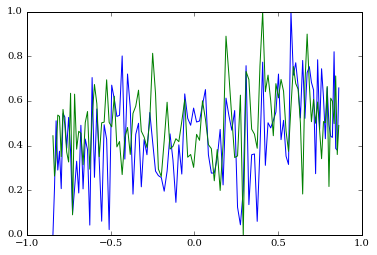

In [10]:
print qvalue[qidx]
plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],normalize(ave_clustered_ac[qidx]) )
plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset], normalize(ave_no_clus_ac[qidx]) )#-0.5e7)
# plt.xlim(0,120)

# plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],normalize(ave_norm_clustered_ac) )
# plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset], normalize(ave_norm_no_clus_ac) )

plt.legend()

x = normalize(ave_no_clus_ac[qidx])
print np.abs(x-x[::-1]).mean()

x = normalize(ave_clustered_ac[qidx]) 
print np.abs(x-x[::-1]).mean()

337
345
295
6.06329801182e-13
5.65222696017e-14
2.08104719897e-13
4.8557767976e-13
3.08303288737e-14


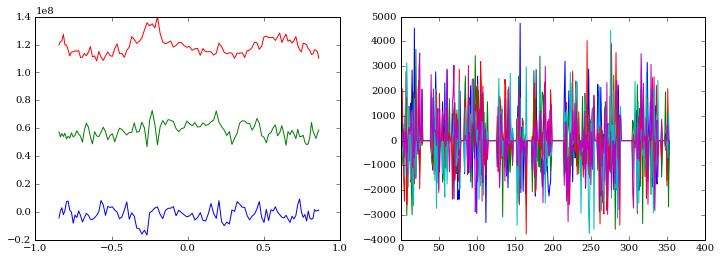

In [11]:
plt.figure(figsize=[12,4])
plt.subplot(121)
for ii in range(0,3):
    print num_shots[ii]
    plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],ave_cluster_single_corr[ii][qidx]+6e7*ii)

plt.subplot(122)
for ii in range(0,5):
#     plt.plot( (ave_cluster_shots[ii][qidx]+ 1e3*ii- shots_to_use.mean(0)[qidx])*mask[qidx])
    plt.plot( ave_cluster_shots[ii][qidx])
    print ave_cluster_shots[ii][qidx].mean()
# plt.ylim(-1e8,3e8)

(-0.8, 0.8)

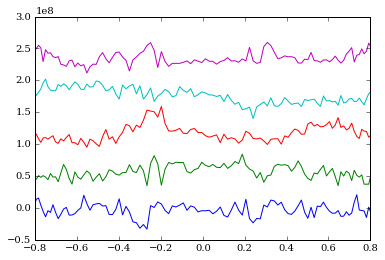

In [12]:
for ii in range(0,5):
    plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],
             ave_cluster_corr[ii][qidx, phi_offset:num_phi/2-phi_offset]+6e7*ii)
# plt.ylim(-1e8,3e8)
plt.xlim(-0.8,0.8)

array([ 6, 10,  4,  5,  7,  1,  9, 14, 13, 11,  0,  8,  3,  2, 12])

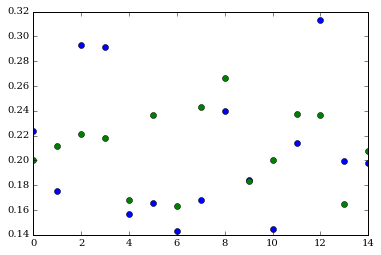

In [13]:
cluster_cor_asym =[] 
no_cluster_asym=[]
for ii ,cc in enumerate(ave_cluster_corr):
    nc=normalize(cc[qidx, phi_offset:num_phi/2-phi_offset])
#     plt.plot(nc)
    cluster_cor_asym.append( (np.abs(nc-nc[::-1])).mean() )
    if ii+1<len(num_shots):
        nc = normalize(no_cluster_ac[num_shots[:ii].sum():num_shots[:ii+1].sum(),
                                     qidx,phi_offset:num_phi/2-phi_offset].mean(0))
    else:
        nc = normalize(no_cluster_ac[num_shots[:ii].sum():
                                     ,qidx,phi_offset:num_phi/2-phi_offset].mean(0))
    no_cluster_asym.append((np.abs(nc-nc[::-1])).mean())
cluster_cor_asym=np.array(cluster_cor_asym)
no_cluster_asym = np.array(no_cluster_asym)
plt.figure()
# plt.subplot(211)
plt.plot(cluster_cor_asym,'o')
# plt.subplot(212)
plt.plot(no_cluster_asym,'o')
cluster_cor_asym.argsort()

[ 1  4  5  6  7  9 10 13 14]
1718
4996
0.183324922127
0.190692163684


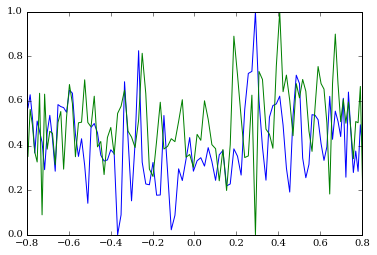

In [14]:
x =None
n = 0
# for ii in np.where(cluster_cor_asym<no_cluster_asym.mean())[0]:
for ii in cluster_cor_asym.argsort()[:5]:
    
    if x is None:
        x = ave_cluster_corr[ii][qidx, phi_offset:num_phi/2-phi_offset]*num_shots[ii]
    else:
        x+=ave_cluster_corr[ii][qidx, phi_offset:num_phi/2-phi_offset]*num_shots[ii]
    n+=num_shots[ii]
    
plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],
             normalize(x/float(n)) )
# plt.ylim(-1e8,3e8)
plt.xlim(-0.8,0.8)
# plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],
#              normalize(no_cluster_ac[:num_shots[ii],qidx,phi_offset:num_phi/2-phi_offset].mean(0)))
print np.where(cluster_cor_asym<no_cluster_asym.mean())[0]
print n
print total_num_shots

plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset], normalize(ave_no_clus_ac[qidx]) )#-0.5e7)

x = normalize(x) 
print np.abs(x-x[::-1]).mean()

x = normalize(ave_no_clus_ac[qidx])
print np.abs(x-x[::-1]).mean()



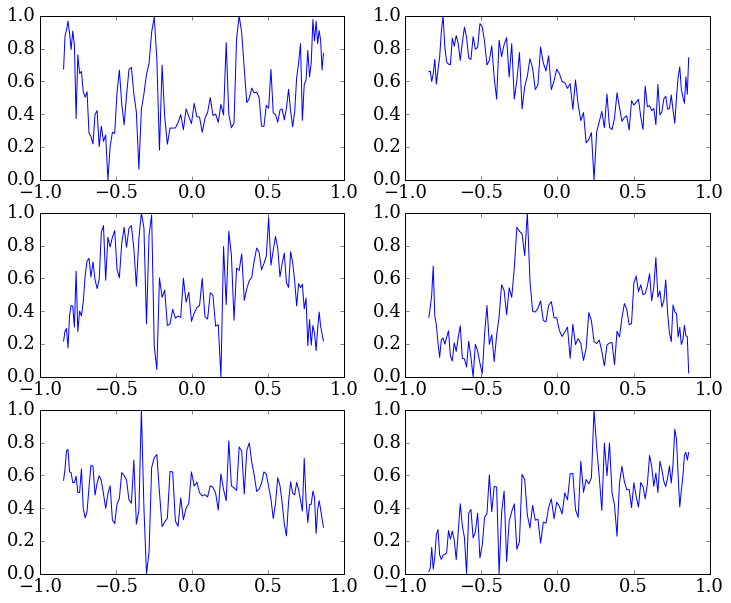

In [29]:
plt.figure(figsize=[12,10])
gs = GridSpec(3,2)
for idx,ii in enumerate(cluster_cor_asym.argsort()[2:5]):
    plt.subplot(gs[idx,0])
   
    x = ave_cluster_corr[ii][qidx, phi_offset:num_phi/2-phi_offset]
    
    
    plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],
                 normalize(x) )
    
for idx,ii in enumerate(cluster_cor_asym.argsort()[-3:]):
    plt.subplot(gs[idx,1])
   
    x = ave_cluster_corr[ii][qidx, phi_offset:num_phi/2-phi_offset]
    
    
    plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],
                 normalize(x) )

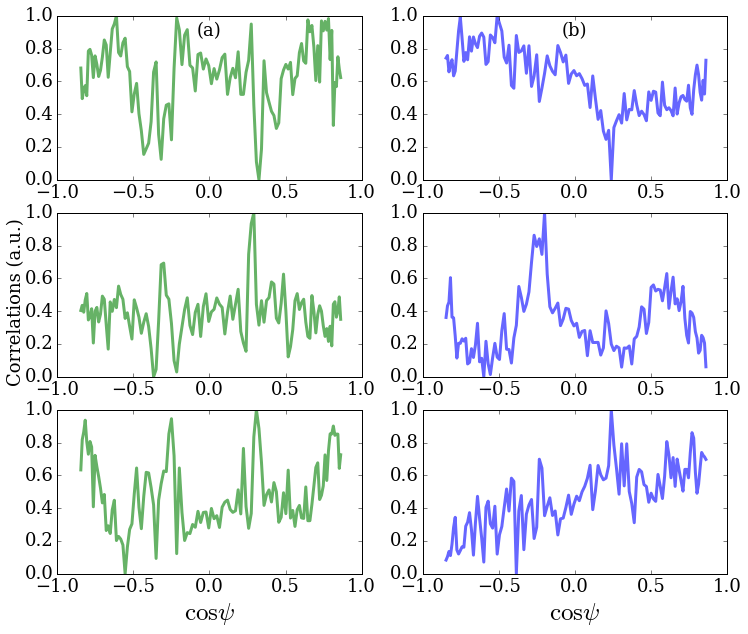

In [33]:
fig=plt.figure(figsize=[12,10])
gs = GridSpec(3,2)
fig.text(s='Correlations (a.u.)', rotation='vertical', x= 0.067, y = 0.6, fontsize = 18)
for idx,ii in enumerate(cluster_cor_asym.argsort()[:3]):
    ax = plt.subplot(gs[idx,0])
   
    x = ave_cluster_single_corr[ii][qidx]

    
    plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],
                 normalize(x) 
            , linewidth=3, alpha=0.6,color='green')
    if idx==0:
        ax.set_title('(a)', x= 0.5,y =0.85, fontsize = 18)
    if idx==2:
        plt.xlabel('$\cos{\psi}$', fontsize = 25)
        
for idx,ii in enumerate(cluster_cor_asym.argsort()[-3:]):
    ax = plt.subplot(gs[idx,1])
   
    x = ave_cluster_single_corr[ii][qidx]
    
    
    plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],
                 normalize(x)
             , linewidth=3, alpha=0.6,color='blue' )
    
    if idx==0:
        ax.set_title('(b)', x= 0.5,y =0.85, fontsize = 18)
    if idx==2:
        plt.xlabel('$\cos{\psi}$', fontsize = 25)
# plt.savefig('cluster_single_shot_corrs.png')

In [192]:
print num_shots[cluster_cor_asym.argsort()[-3:]]
print num_shots[cluster_cor_asym.argsort()[2:5]]

[305 340 284]
[328 311 382]


In [324]:
def _remove_duplicate_pairs(pairs_dict):
    pairs = []
    for k, v in pairs_dict.iteritems():
        set_p = set((int(k), int(v)))
        if set_p not in pairs:
            pairs.append(set_p)
    return [[i, j] for i, j in pairs]

def pair_diff_PI(corr, 
    qidx_pair = 25,
    phi_offset=10):
    print("doing corr pairing...")

    
    eps = distance.cdist(corr[:,qidx_pair],corr[:,qidx_pair], metric='cosine')
    # do this so the diagonals are not the minimum, i.e. don't pair shot with itself
    epsI = 1.1 * eps.max(1) * np.identity(eps.shape[0])
    eps += epsI

    shot_preference = np.roll(eps.argsort(1), 1, axis=1)
    pref_dict = {str(E[0]): list(E[1:])
             for E in shot_preference.astype(str)}

    print("stable roommate pair....")
    pairs_dict = stable.stableroomate(prefs=pref_dict)
    
    pairing = np.array(_remove_duplicate_pairs(pairs_dict) )
    return pairing


In [325]:
print cluster_cor_asym.argsort()

[11  2  4  9 14  1 10  6  7  8 13  5  0  3 12]


In [332]:

select = kmeans.labels_==3
print "num of shots:%d"%select.sum()
cc= corr[select]
ss = norm_shots[select]
pairing=pair_diff_PI(cc, qidx_pair=qidx)
print("computing difference intensities...")
diff_ss = np.zeros( (ss.shape[0]/2, 
    1, 
    norm_shots.shape[-1]), 
    dtype=np.float64 )

for index, pp in enumerate( pairing ):
    diff_ss[index,0] = ss[pp[0],qidx]-ss[pp[1],qidx]


num of shots:680
doing corr pairing...
stable roommate pair....
computing difference intensities...


In [333]:
qs=np.array([1.0])

dc = DiffCorr(diff_ss,
  qs,0,pre_dif=True)
corr_pair = dc.autocorr()/ mask_ac[0,qidx]
corr_pair=corr_pair.mean(0)[0, phi_offset:num_phi/2-phi_offset]


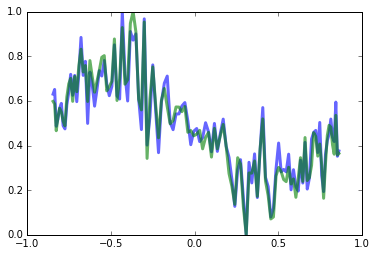

In [334]:
plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],
                 normalize(corr_pair)
             , linewidth=3, alpha=0.6,color='blue' )
    
plt.plot(exp_cpsi[qidx, phi_offset:num_phi/2-phi_offset],
                 normalize(cc.mean(0)[qidx])
             , linewidth=3, alpha=0.6,color='green' )

In [335]:
diff_ss2 = ss[1::2]-ss[::2]

In [314]:
np.abs(diff_ss2.mean(-1)).mean()
np.abs(diff_ss.mean(-1)).mean()

2.9024886129769335e-12

(0, 250)

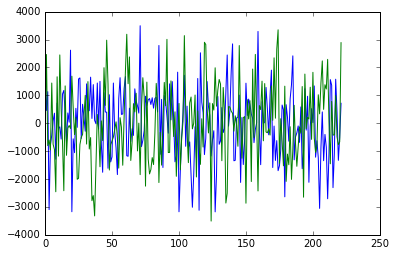

In [317]:
plt.plot(diff_ss2.mean(0)[qidx][mask[qidx]],'-')
plt.plot(diff_ss.mean(0)[0][mask[qidx]],'-')
plt.xlim(0,250)

In [300]:
diff_ss2.mean(0)[qidx][mask[qidx]].mean(),diff_ss.mean(0)[0][mask[qidx]].mean()
diff_ss2.mean(0)[qidx][mask[qidx]].std(),diff_ss.mean(0)[0][mask[qidx]].std()

(1435.077489562357, 1414.8619197286271)